In [ ]:
import requests, json, time, pandas as pd, numpy as np
# your api key on last.fm
key =
# your username on last.fm
username =

In [ ]:
def get_artist_tags(artist, key=key, autocorrect=1):
  '''
  artist: artist name
  key: your api key
  '''
  # url request
  url = 'http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={}&api_key={}&format=json'
  # list to store all responses
  responses = []
  # list to store genres of artist music
  tags = [[]]

  # make request
  request_url = url.format(artist, key, autocorrect)
  responses.append(requests.get(request_url))

  for response in responses:
    scrobbles = response.json()
    if 'artist' in scrobbles:
      for scrobble in scrobbles['artist']['tags']['tag']:
        # 'seen live' is last.fm tag for artist that most users have seen live, we don't need it
        if scrobble['name']!='seen live' and scrobble['name']!='russian':
          tags.append(scrobble['name']) 

  return tags

In [ ]:
def get_track_duration(artist, track, key=key, autocorrect=1):
  '''
  '''
  url = 'http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={}&artist={}&track={}&format=json'
  responses=[]
  track_info=[]
  duration=[]
  tags=[]
  track_name=[]

  # make first request
  request_url = url.format(key, artist, track, autocorrect)
  print(request_url)
  responses.append(requests.get(request_url))

  for response in responses:
    scrobbles = response.json()
    print(scrobbles.keys())
    if 'track' in scrobbles:
      for scrobble in scrobbles['track']['toptags']['tag']:
        if scrobble['name']!='seen live' and scrobble['name']!='russian':
          tags.append(scrobble['name'])
      duration.append(int(scrobbles['track']['duration']))
    track_name.append(track)

  print(track_name, tuple(tags), duration)

  df = [track_name, duration, tags]

  return df

In [ ]:
# how long to pause between consecutive API requests
pause_duration = 0.2

In [ ]:
def get_scrobbles(method='recenttracks', username=username, key=key, limit=200, extended=0, page=1, pages=0):
    '''
    method: api method
    username/key: api credentials
    limit: api lets you retrieve up to 200 records per call
    extended: api lets you retrieve extended data for each track, 0=no, 1=yes
    page: page of results to start retrieving at
    pages: how many pages of results to retrieve. if 0, get as many as api can return.
    '''
    # initialize url and lists to contain response fields
    url = 'https://ws.audioscrobbler.com/2.0/?method=user.get{}&user={}&api_key={}&limit={}&extended={}&page={}&format=json'
    responses = []
    artist_names = []
    album_names = []
    track_names = []
    timestamps = []
    duration = []
    tags = []
    
    # make first request, just to get the total number of pages
    request_url = url.format(method, username, key, limit, extended, page)
    print(request_url)
    response = requests.get(request_url).json()
    total_pages = int(response[method]['@attr']['totalPages'])
    if pages > 0:
        total_pages = min([total_pages, pages])
        
    print('{} total pages to retrieve'.format(total_pages))
    
    # request each page of data one at a time
    for page in range(1, int(total_pages) + 1, 1):
        if page % 10 == 0: print(page, end=' ')
        time.sleep(pause_duration)
        request_url = url.format(method, username, key, limit, extended, page)
        responses.append(requests.get(request_url))
    
    # parse the fields out of each scrobble in each page (aka response) of scrobbles
    for response in responses:
        scrobbles = response.json()
        for scrobble in scrobbles[method]['track']:
            # only retain completed scrobbles (aka, with timestamp and not 'now playing')
            if 'date' in scrobble.keys():
                artist_names.append(scrobble['artist']['#text'].replace(' & ', '&'))
                album_names.append(scrobble['album']['#text'])
                track_names.append(scrobble['name'].replace(' & ', '&'))
                timestamps.append(scrobble['date']['uts'])

    for track_name, artist_name in zip(track_names, artist_names):
      duration.append(get_track_duration(artist_name, track_name)[1])
      tags.append((get_track_duration(artist_name, track_name)[2]))
                
    # create and populate a dataframe to contain the data
    df = pd.DataFrame()
    df['artist'] = artist_names
    df['album'] = album_names
    df['track'] = track_names
    df['timestamp'] = timestamps
    df['datetime'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
    df['track duration'] = duration
    df['tags'] = tags
    
    return df

In [ ]:
# get all scrobbled tracks ever, in order of recency (pages=0 to get all)
scrobbles = get_scrobbles(pages=5)

Streaming output truncated to the last 5000 lines.
dict_keys(['track'])
['On Air'] () [0]
http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key=8d086606d81fedaeb37ab3d5b89ae00c&artist=Aarne&track=БИЗНЕС ВУМЕН&format=json
dict_keys(['track'])
['БИЗНЕС ВУМЕН'] () [0]
http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key=8d086606d81fedaeb37ab3d5b89ae00c&artist=Aarne&track=БИЗНЕС ВУМЕН&format=json
dict_keys(['track'])
['БИЗНЕС ВУМЕН'] () [0]
http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key=8d086606d81fedaeb37ab3d5b89ae00c&artist=Aarne&track=Discord&format=json
dict_keys(['track'])
['Discord'] () [0]
http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key=8d086606d81fedaeb37ab3d5b89ae00c&artist=Aarne&track=Discord&format=json
dict_keys(['track'])
['Discord'] () [0]
http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key=8d086606d81fedaeb37ab3d5b89ae00c&artist=Aarne&track=Больно&format=json
dict_keys(['track'])
['Больно'] () [0]
http://ws.audiosc

In [ ]:
# save the dataset
scrobbles.to_csv('lastfm_scrobbles.csv', index=None, encoding='utf-8')
print('{:,} total rows'.format(len(scrobbles)))
scrobbles.head()

1,000 total rows


,artist,album,track,timestamp,datetime,track duration,tags
0,k u r a i,Radioactive Princess,THROWING A LOW PASS,1670268153,2022-12-05 19:22:33,[0],[]
1,grust200,Иволга,Иволга,1670267945,2022-12-05 19:19:05,[147000],[]
2,V21,You Are Everything I Need,You Are Everything I Need,1670267765,2022-12-05 19:16:05,[179000],[]
3,pavluchenko,холодным,холодным,1670267583,2022-12-05 19:13:03,[182000],[]
4,onimanxd,YOUR EYES,YOUR EYES,1670267429,2022-12-05 19:10:29,[153000],[]


In [ ]:
scrobbles['datetime']=scrobbles['datetime'].dt.strftime('%d.%m')

In [ ]:
scrobbles.head(10)

,artist,album,track,timestamp,datetime,track duration,tags
0,k u r a i,Radioactive Princess,THROWING A LOW PASS,1670268153,2022-12-05 19:22:33,[0],[]
1,grust200,Иволга,Иволга,1670267945,2022-12-05 19:19:05,[147000],[]
2,V21,You Are Everything I Need,You Are Everything I Need,1670267765,2022-12-05 19:16:05,[179000],[]
3,pavluchenko,холодным,холодным,1670267583,2022-12-05 19:13:03,[182000],[]
4,onimanxd,YOUR EYES,YOUR EYES,1670267429,2022-12-05 19:10:29,[153000],[]
5,Nürnberg,Mora,Mora,1670267318,2022-12-05 19:08:38,[195000],[]
6,Мы,"Расстояние, Pt. 3",возможно,1670267197,2022-12-05 19:06:37,[0],"[pop, experimental, indie pop, synth pop]"
7,АДЛИН,New World,New World,1670267061,2022-12-05 19:04:21,[134000],[]
8,Rixat,Cyberpsychosis,Cyberpsychosis,1670266884,2022-12-05 19:01:24,[177000],[]
9,fem.love,1000-7,1000-7,1670266766,2022-12-05 18:59:26,[117000],[]


In [ ]:
check = list(scrobbles['tags'])
check = np.array([x for sublist in check for x in sublist])
check[~np.char.isnumeric(check)]
unique, counts = np.unique(check, return_counts=True)
tags_df = pd.DataFrame({'tag': unique, 'frequency': counts})

In [ ]:
tags_df

,tag,frequency
0,#Христианский Hip-hop,1
1,10s,1
2,1979,1
3,1980,1
4,2 cool,1
...,...,...
206,underground hip-hop,3
207,west coast,2
208,wrong tags,1
209,wypierdalac,1


In [ ]:
tags_df=tags_df.sort_values(by='frequency', ascending=False).head(10).reset_index(drop=True).set_index('tag')

In [ ]:
tags_df

,frequency
tag,
Hip-Hop,50
rap,47
punk,35
trap,35
indie,34
rock,33
electronic,28
alternative,28
industrial jungle pussy punk,26


In [ ]:
import seaborn as sns
sns.set_theme()

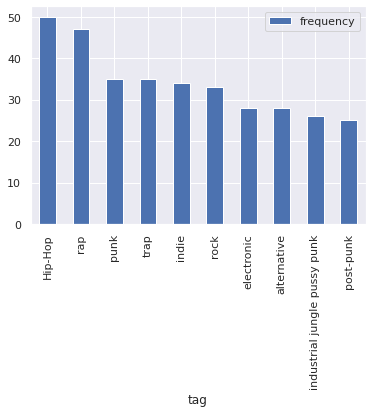

In [ ]:
tags_df.plot(kind='bar')